In [78]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso

from sklearn.decomposition import PCA
from scipy.fft import fft, rfft
from scipy.fft import fftfreq, rfftfreq

import torch
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch import Trainer

from shared_decoding.utils.ibl_data_utils import seed_everything
from shared_decoding.utils.ibl_data_loaders import SingleSessionDataModule, to_tensor
from shared_decoding.models.neural_models import eval_model

seed_everything(0)

In [2]:
base_dir = Path('/mnt/3TB/yizi/shared_decoding')
data_dir = base_dir/'data'

eids = [fname.split('.')[0] for fname in os.listdir(data_dir) if fname.endswith('npz')]
print(eids)

['d32876dd-8303-4720-8e7e-20678dc2fd71', '3f859b5c-e73a-4044-b49e-34bb81e96715', '12dc8b34-b18e-4cdd-90a9-da134a9be79c', 'cc45c568-c3b9-4f74-836e-c87762e898c8']


In [94]:
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
model = GridSearchCV(Ridge(), {"alpha": alphas})

In [4]:
import numba

def behavior_decomp(eid, target, model, model_class, data_dir, decomp_type='PCA'):

    DEVICE = torch.device('cpu')

    config = {
        'data_dir': data_dir,
        'temporal_rank': 5,
        'weight_decay': 1e-1,
        'learning_rate': 1e-2,
        'batch_size': 8,
        'eid': eid,
        'imposter_id': None,
        'target': target,
        'lstm_hidden_size': 32,
        'lstm_n_layers': 3,
        'mlp_hidden_size': (256, 128, 64),
        'drop_out': 0.,
        'lr_factor': 0.1,
        'lr_patience': 5,
        'device': DEVICE,
        'n_workers': os.cpu_count()
    }

    dm = SingleSessionDataModule(config)
    dm.setup()

    train_y = []
    for (x, y) in dm.train:
        train_y.append(y.cpu())
    train_y = torch.stack(train_y)
    
    val_y = []
    for (x, y) in dm.val:
        val_y.append(y.cpu())
    val_y = np.stack(val_y)
    
    test_y = []
    for (x, y) in dm.test:
        test_y.append(y.cpu())
    test_y = np.stack(test_y)

    all_y = np.vstack([train_y, val_y, test_y])

    r2, test_pred, test_y = eval_model(dm.train, dm.test, model, model_type=model_class, plot=False)

    # PCA 
    if decomp_type == 'PCA':
        pca = PCA(n_components=config['n_t_steps'])
        pca.fit(all_y.reshape((-1, config['n_t_steps'])))
        pca_basis = pca.components_
        pca_var_explained = pca.explained_variance_ratio_
    
        signal_decomp = (pca_basis @ test_y.transpose()).var(-1)
        recon_decomp = (pca_basis @ test_pred.transpose()).var(-1)
        error_decomp = (pca_basis @ (test_pred - test_y).transpose()).var(-1)
        return signal_decomp, recon_decomp, error_decomp, pca_var_explained, r2, test_pred, test_y

    # Fourier
    if decomp_type == 'Fourier':

        @numba.vectorize([numba.float64(numba.complex128),numba.float32(numba.complex64)])
        def norm(x):
            return x.real**2 + x.imag**2
        
        def fourier_decomp(data, config, delta_t=20):
            N = config['n_t_steps']
            delta_t = 20 # ms
            sampling_rate = 2*config['n_t_steps']*delta_t
            freq = np.abs(fftfreq(N, d=1/sampling_rate))
            fft_coef = fft(data)
            decomp = []
            for f in np.unique(freq):
                sp = 0
                for idx in np.argwhere(freq == f):
                    sp += norm(fft_coef[:,idx]).mean()
                decomp.append(np.mean(sp))
            decomp = np.array(decomp)
            return decomp

        signal_decomp = fourier_decomp(test_y, config, delta_t=20)
        recon_decomp = fourier_decomp(test_pred, config, delta_t=20)
        error_decomp = fourier_decomp(test_pred - test_y, config, delta_t=20)
        return signal_decomp, recon_decomp, error_decomp, _, r2, test_pred, test_y


In [105]:
def recon_from_pcs(y, pca, comp_idx=0):
    recon_y = np.dot(pca.transform(y)[:,comp_idx,None], pca.components_[None,comp_idx,:])
    recon_y += pca.mean_
    return recon_y    

def r2_decomp(eid, target, model, model_class, data_dir, n_comp=30):

    DEVICE = torch.device('cpu')

    config = {
        'data_dir': data_dir,
        'temporal_rank': 5,
        'weight_decay': 1e-1,
        'learning_rate': 1e-2,
        'batch_size': 8,
        'eid': eid,
        'imposter_id': None,
        'target': target,
        'lstm_hidden_size': 32,
        'lstm_n_layers': 3,
        'mlp_hidden_size': (256, 128, 64),
        'drop_out': 0.,
        'lr_factor': 0.1,
        'lr_patience': 5,
        'device': DEVICE,
        'n_workers': os.cpu_count()
    }

    dm = SingleSessionDataModule(config)
    dm.setup()

    def decode_per_pc_component(comp_idx):

        train_x, train_y = [], []
        for (x, y) in dm.train:
            train_x.append(x.cpu())
            train_y.append(y.cpu())
        train_x = np.stack(train_x)
        train_y = np.stack(train_y)
        
        val_x, val_y = [], []
        for (x, y) in dm.val:
            val_x.append(x.cpu())
            val_y.append(y.cpu())
        val_x = np.stack(val_x)
        val_y = np.stack(val_y)
        
        test_x, test_y = [], []
        for (x, y) in dm.test:
            test_x.append(x.cpu())
            test_y.append(y.cpu())
        test_x = np.stack(test_x)
        test_y = np.stack(test_y)
        
        all_y = np.vstack([train_y, val_y, test_y])
    
        pca = PCA(n_components=config['n_t_steps'])
        pca.fit(all_y)

        _train_y = recon_from_pcs(train_y, pca, comp_idx=comp_idx)
        _test_y = recon_from_pcs(test_y, pca, comp_idx=comp_idx)

        _train = [(to_tensor(train_x[i], DEVICE), to_tensor(_train_y[i], DEVICE)) for i in range(len(train_x))]
        _test = [(to_tensor(test_x[i], DEVICE), to_tensor(_test_y[i], DEVICE)) for i in range(len(test_x))]

        r2, _, _ = eval_model(_train, _test, model, model_type='ridge', plot=False)

        return r2

    r2, _, _ = eval_model(dm.train, dm.test, model, model_type='ridge', plot=False)
    print(f'Original Data R2: {r2}')
    r2s = [r2]
    for comp_idx in range(n_comp):
        r2 = decode_per_pc_component(comp_idx)
        print(f'PC {comp_idx+1} R2: {r2}')
        r2s.append(r2)
    return r2s

##### PCA Behavior Decomposition

In [ ]:
eid = eids[0]
target = 'wheel_speed'

In [ ]:
signal_decomp, recon_decomp, error_decomp, pca_var_explained = behavior_decomp(
    eids[0], target=target, 
    model=model, model_class='ridge', data_dir=data_dir, decomp_type='PCA'
)

In [ ]:
plt.figure(figsize=(3,2))
plt.bar(np.arange(len(pca_var_explained)), pca_var_explained)
plt.title(f'{eid[:8]}')
plt.xlabel('PCA component')
plt.ylabel('Explained variance');

In [ ]:
plt.figure(figsize=(3,2))
plt.plot(signal_decomp, c='gray', linewidth=3, alpha=.5, label='behavior')
plt.plot(recon_decomp, c='orange', linewidth=1.5, alpha=1., label='pred')
plt.plot(error_decomp, c='k', linewidth=1, alpha=1., linestyle='--', label='error (pred - behavior)')
plt.title(f'{target} ({eid[:8]})')
plt.legend(frameon=False);

##### Fourier Behavior Decomposition

In [ ]:
signal_decomp, recon_decomp, error_decomp, pca_var_explained = behavior_decomp(
    eids[0], target=target, 
    model=model, model_class='ridge', data_dir=data_dir, decomp_type='Fourier'
)

In [ ]:
plt.figure(figsize=(3,2))
plt.plot(signal_decomp, c='gray', linewidth=3, alpha=.5, label='behavior')
plt.plot(recon_decomp, c='orange', linewidth=1.5, alpha=1., label='pred')
plt.plot(error_decomp, c='k', linewidth=1, alpha=1., linestyle='--', label='error (pred - behavior)')
plt.title(f'{target} ({eid[:8]})')
plt.xlabel('frequency')
plt.legend(frameon=False);

spike data shape: (414, 50, 408)
behavior data shape: (414, 50)
spike data shape: (414, 50, 408)
behavior data shape: (414, 50)
spike data shape: (490, 50, 1839)
behavior data shape: (490, 50)
spike data shape: (490, 50, 1839)
behavior data shape: (490, 50)
spike data shape: (907, 50, 245)
behavior data shape: (907, 50)
spike data shape: (907, 50, 245)
behavior data shape: (907, 50)
spike data shape: (715, 50, 2263)
behavior data shape: (715, 50)
spike data shape: (715, 50, 2263)
behavior data shape: (715, 50)


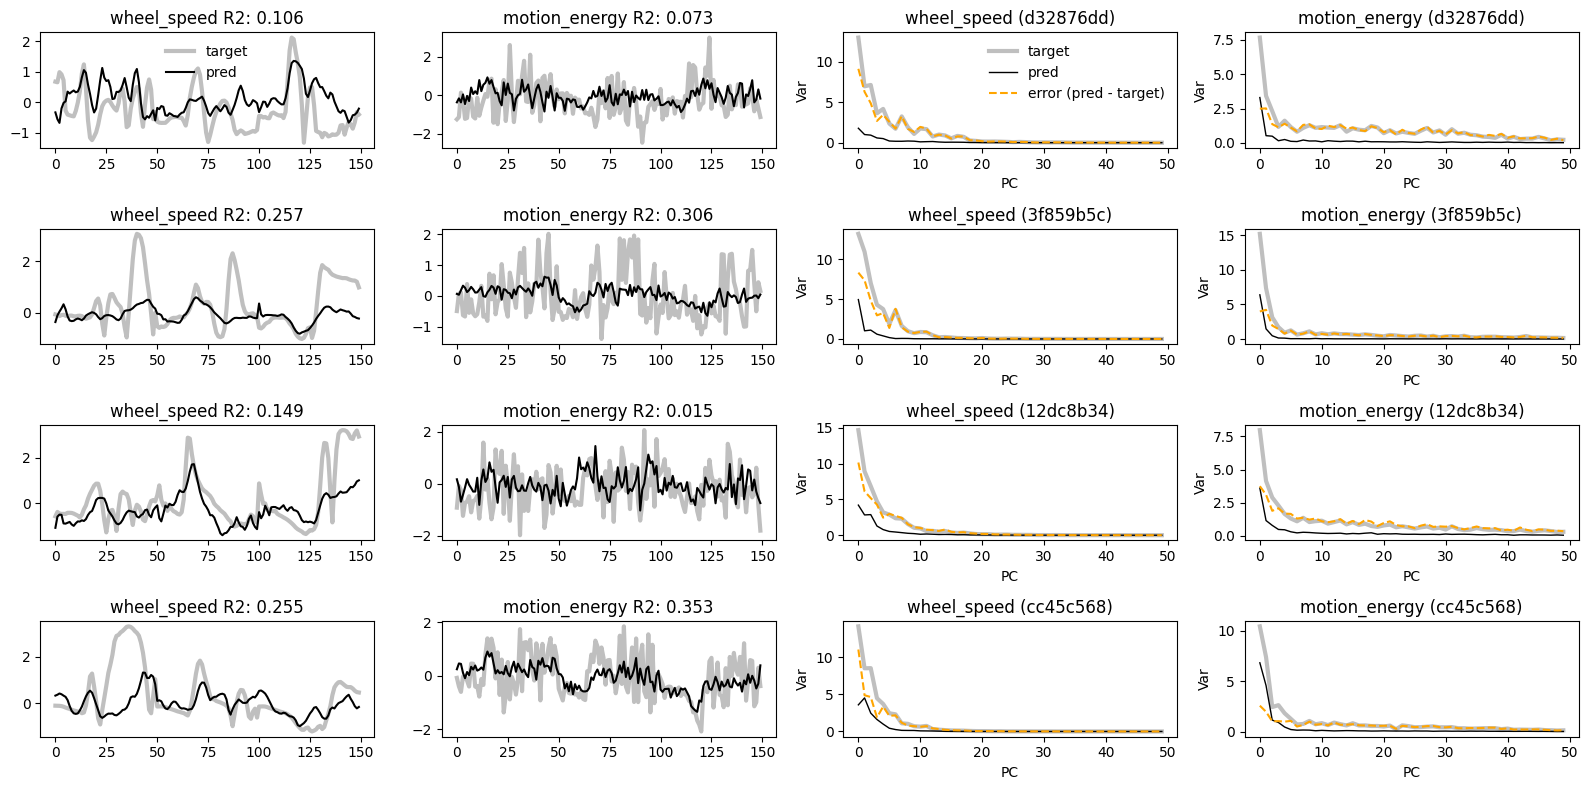

In [5]:
model_class = 'ridge'
n_eids = len(eids)
targets = ['wheel_speed', 'motion_energy']
fig, axes = plt.subplots(n_eids, len(targets)+2, figsize=(4*len(targets)*2, 2*n_eids))

for i, eid in enumerate(eids):
    for j, target in enumerate(targets):        
        signal_decomp, recon_decomp, error_decomp, pca_var_explained, r2, test_pred, test_y = behavior_decomp(
            eid, target=target, 
            model=model, model_class=model_class, data_dir=data_dir, decomp_type='PCA'
        )
        axes[i,j].plot(test_y[:3].flatten(), c='gray', linewidth=3, alpha=.5, label='target')
        axes[i,j].plot(test_pred[:3].flatten(), c='k', linewidth=1.5, alpha=1., label='pred')
        axes[i,j].set_title(f'{target} R2: {r2:.3f}')
            
        axes[i,j+2].plot(signal_decomp, c='gray', linewidth=3, alpha=.5, label='target')
        axes[i,j+2].plot(recon_decomp, c='k', linewidth=1., alpha=1., label='pred')
        axes[i,j+2].plot(error_decomp, c='orange', linewidth=1.5, alpha=1., linestyle='--', label='error (pred - target)')
        axes[i,j+2].set_title(f'{target} ({eid[:8]})')
        axes[i,j+2].set_xlabel('PC')
        axes[i,j+2].set_ylabel('Var')
        if np.logical_and(i == 0, j == 0):
            axes[i,0].legend(frameon=False)
            axes[i,2].legend(frameon=False)
            
plt.tight_layout()
plt.savefig('../results/plots/pca_behavior_decomp.png', dpi=200)

spike data shape: (414, 50, 408)
behavior data shape: (414, 50)
spike data shape: (414, 50, 408)
behavior data shape: (414, 50)
spike data shape: (490, 50, 1839)
behavior data shape: (490, 50)
spike data shape: (490, 50, 1839)
behavior data shape: (490, 50)
spike data shape: (907, 50, 245)
behavior data shape: (907, 50)
spike data shape: (907, 50, 245)
behavior data shape: (907, 50)
spike data shape: (715, 50, 2263)
behavior data shape: (715, 50)
spike data shape: (715, 50, 2263)
behavior data shape: (715, 50)


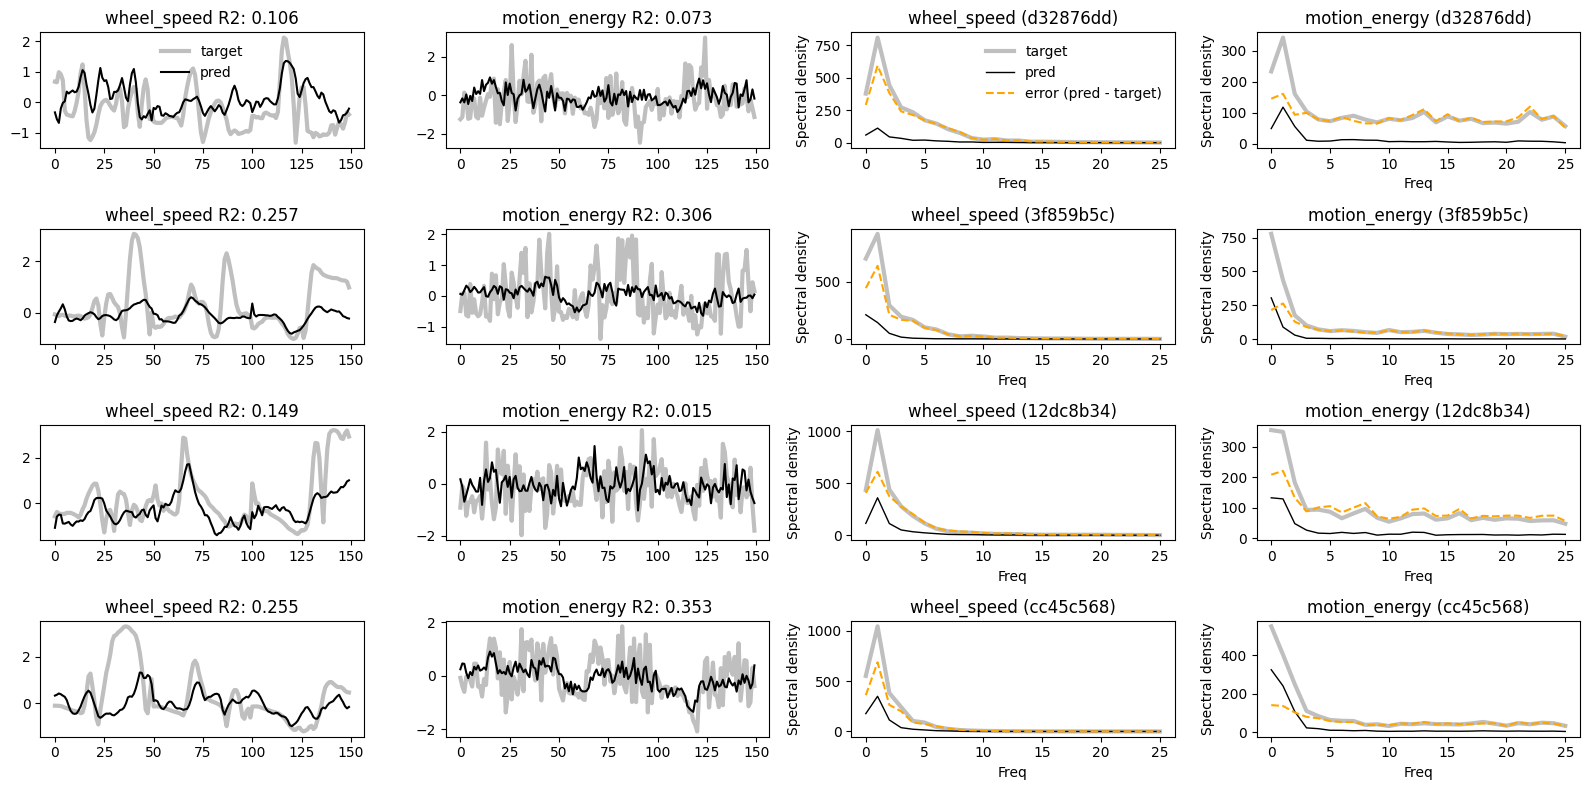

In [6]:
model_class = 'ridge'
n_eids = len(eids)
targets = ['wheel_speed', 'motion_energy']
fig, axes = plt.subplots(n_eids, len(targets)+2, figsize=(4*len(targets)*2, 2*n_eids))

for i, eid in enumerate(eids):
    for j, target in enumerate(targets):        
        signal_decomp, recon_decomp, error_decomp, pca_var_explained, r2, test_pred, test_y = behavior_decomp(
            eid, target=target, 
            model=model, model_class=model_class, data_dir=data_dir, decomp_type='Fourier'
        )
        axes[i,j].plot(test_y[:3].flatten(), c='gray', linewidth=3, alpha=.5, label='target')
        axes[i,j].plot(test_pred[:3].flatten(), c='k', linewidth=1.5, alpha=1., label='pred')
        axes[i,j].set_title(f'{target} R2: {r2:.3f}')
            
        axes[i,j+2].plot(signal_decomp, c='gray', linewidth=3, alpha=.5, label='target')
        axes[i,j+2].plot(recon_decomp, c='k', linewidth=1., alpha=1., label='pred')
        axes[i,j+2].plot(error_decomp, c='orange', linewidth=1.5, alpha=1., linestyle='--', label='error (pred - target)')
        axes[i,j+2].set_title(f'{target} ({eid[:8]})')
        axes[i,j+2].set_xlabel('Freq')
        axes[i,j+2].set_ylabel('Spectral density')
        if np.logical_and(i == 0, j == 0):
            axes[i,0].legend(frameon=False)
            axes[i,2].legend(frameon=False)
            
plt.tight_layout()
plt.savefig('../results/plots/fourier_behavior_decomp.png', dpi=200)

##### Decode Each Component

In [5]:
eid = eids[0]
target = 'wheel_speed'

In [ ]:
DEVICE = torch.device('cpu')

config = {
    'data_dir': data_dir,
    'temporal_rank': 5,
    'weight_decay': 1e-1,
    'learning_rate': 1e-2,
    'batch_size': 8,
    'eid': eid,
    'imposter_id': None,
    'target': target,
    'lstm_hidden_size': 32,
    'lstm_n_layers': 3,
    'mlp_hidden_size': (256, 128, 64),
    'drop_out': 0.,
    'lr_factor': 0.1,
    'lr_patience': 5,
    'device': DEVICE,
    'n_workers': os.cpu_count()
}

dm = SingleSessionDataModule(config)
dm.setup()

In [95]:
train_x, train_y = [], []
for (x, y) in dm.train:
    train_x.append(x.cpu())
    train_y.append(y.cpu())
train_x = np.stack(train_x)
train_y = np.stack(train_y)

val_x, val_y = [], []
for (x, y) in dm.val:
    val_x.append(x.cpu())
    val_y.append(y.cpu())
val_x = np.stack(val_x)
val_y = np.stack(val_y)

test_x, test_y = [], []
for (x, y) in dm.test:
    test_x.append(x.cpu())
    test_y.append(y.cpu())
test_x = np.stack(test_x)
test_y = np.stack(test_y)

all_y = np.vstack([train_y, val_y, test_y])

In [96]:
pca = PCA(n_components=config['n_t_steps'])
pca.fit(all_y)
pca_basis = pca.components_
pca_var_explained = pca.explained_variance_ratio_

In [98]:
_train_y = recon_from_pcs(train_y, pca, comp_idx=0)
_test_y = recon_from_pcs(test_y, pca, comp_idx=0)

In [99]:
_train = [(to_tensor(train_x[i], DEVICE), to_tensor(_train_y[i], DEVICE)) for i in range(len(train_x))]
_test = [(to_tensor(test_x[i], DEVICE), to_tensor(_test_y[i], DEVICE)) for i in range(len(test_x))]

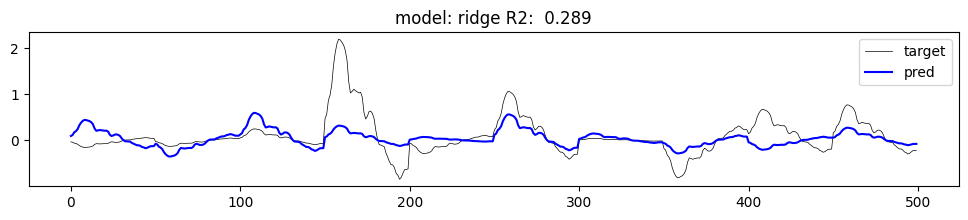

In [100]:
r2, test_pred, test_y = eval_model(_train, _test, model, model_type='ridge', plot=True)

In [111]:
eid = eids[-1]
target = 'wheel_speed'
r2s = r2_decomp(
    eid, target=target, 
    model=model, model_class='ridge', 
    data_dir=data_dir, n_comp=10
)

spike data shape: (715, 50, 2263)
behavior data shape: (715, 50)
Original Data R2: 0.255386318147989
PC 1 R2: 0.2067975685749446
PC 2 R2: 0.4253051144008282
PC 3 R2: 0.45558976809197405
PC 4 R2: 0.5758152904768431
PC 5 R2: 0.09392016900323182
PC 6 R2: 0.14269868642207467
PC 7 R2: 0.05770208789546892
PC 8 R2: -0.12360072981796595
PC 9 R2: 0.1988316162482842
PC 10 R2: -0.028633700598118282


In [110]:
eid = eids[-1]
target = 'motion_energy'
r2s = r2_decomp(
    eid, target=target, 
    model=model, model_class='ridge', 
    data_dir=data_dir, n_comp=10
)

spike data shape: (715, 50, 2263)
behavior data shape: (715, 50)
Original Data R2: 0.3531389104942869
PC 1 R2: 0.7495165910139971
PC 2 R2: 0.7336950844940842
PC 3 R2: 0.5803694667769682
PC 4 R2: 0.5967642718939707
PC 5 R2: 0.45819331837708416
PC 6 R2: 0.1600597162842651
PC 7 R2: 0.2895795936422972
PC 8 R2: 0.029678992719889677
PC 9 R2: 0.06560330819933163
PC 10 R2: 0.05200686198321065


spike data shape: (414, 50, 408)
behavior data shape: (414, 50)
spike data shape: (414, 50, 408)
behavior data shape: (414, 50)
Original Data R2: 0.10604114162291156
PC 1 R2: 0.28858827884784355
PC 2 R2: 0.09278047100292014
PC 3 R2: 0.30666826869023517
PC 4 R2: 0.23157889498278347
PC 5 R2: 0.16997269878850851
PC 6 R2: -0.12009194631332727
PC 7 R2: -0.01144781406161114
PC 8 R2: -0.02329331720319421
PC 9 R2: 0.10364948889391112
PC 10 R2: -0.2653239324269696
spike data shape: (414, 50, 408)
behavior data shape: (414, 50)
spike data shape: (414, 50, 408)
behavior data shape: (414, 50)
Original Data R2: 0.07299463518531808
PC 1 R2: 0.672104581513638
PC 2 R2: 0.2665634049033015
PC 3 R2: 0.36825009951046617
PC 4 R2: 0.02458952249906334
PC 5 R2: 0.11090101922627524
PC 6 R2: 0.008992136756267567
PC 7 R2: -0.1622114149358775
PC 8 R2: -0.20798368108534418
PC 9 R2: -0.1810847588913854
PC 10 R2: -0.006168019834730174
spike data shape: (490, 50, 1839)
behavior data shape: (490, 50)
spike data shape:

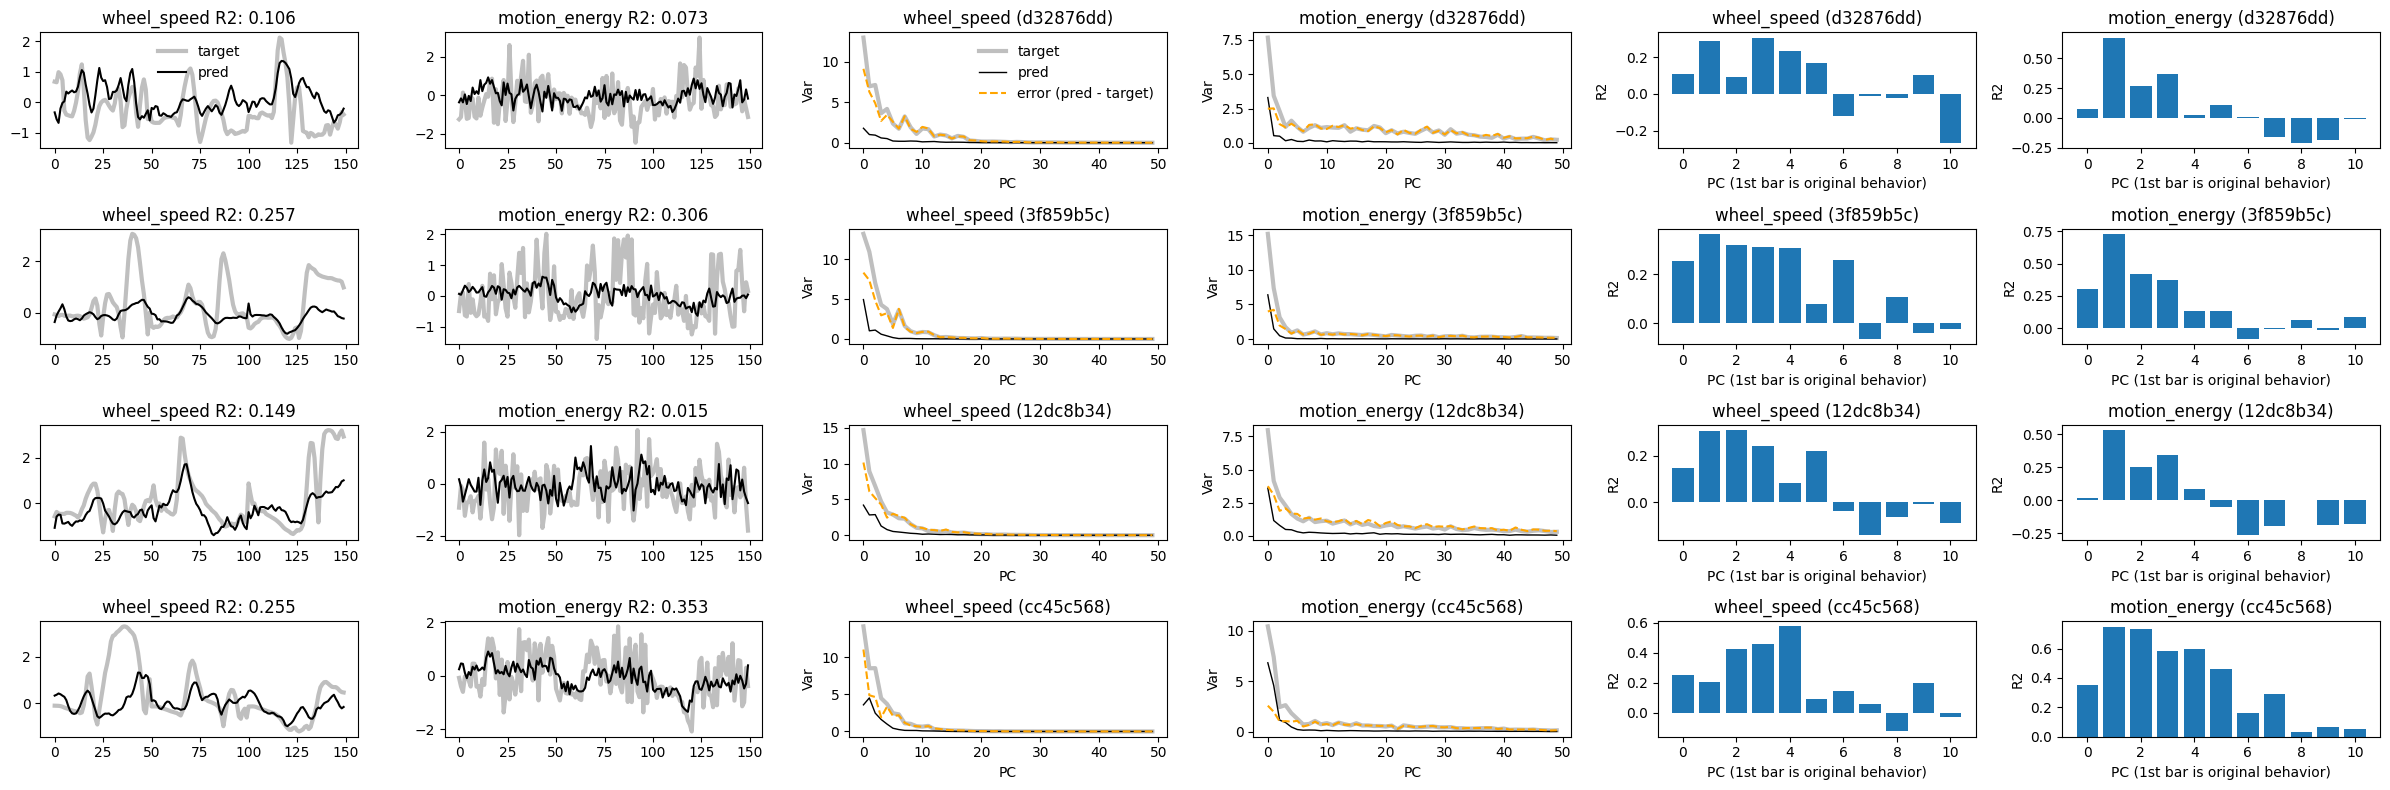

In [117]:
model_class = 'ridge'
n_eids = len(eids)
targets = ['wheel_speed', 'motion_energy']
fig, axes = plt.subplots(n_eids, len(targets)+4, figsize=(4*len(targets)*3, 2*n_eids))

for i, eid in enumerate(eids):
    for j, target in enumerate(targets):        
        signal_decomp, recon_decomp, error_decomp, pca_var_explained, r2, test_pred, test_y = behavior_decomp(
            eid, target=target, 
            model=model, model_class=model_class, data_dir=data_dir, decomp_type='PCA'
        )
        axes[i,j].plot(test_y[:3].flatten(), c='gray', linewidth=3, alpha=.5, label='target')
        axes[i,j].plot(test_pred[:3].flatten(), c='k', linewidth=1.5, alpha=1., label='pred')
        axes[i,j].set_title(f'{target} R2: {r2:.3f}')
            
        axes[i,j+2].plot(signal_decomp, c='gray', linewidth=3, alpha=.5, label='target')
        axes[i,j+2].plot(recon_decomp, c='k', linewidth=1., alpha=1., label='pred')
        axes[i,j+2].plot(error_decomp, c='orange', linewidth=1.5, alpha=1., linestyle='--', label='error (pred - target)')
        axes[i,j+2].set_title(f'{target} ({eid[:8]})')
        axes[i,j+2].set_xlabel('PC')
        axes[i,j+2].set_ylabel('Var')
        if np.logical_and(i == 0, j == 0):
            axes[i,0].legend(frameon=False)
            axes[i,2].legend(frameon=False)

        r2s = r2_decomp(
            eid, target=target, 
            model=model, model_class='ridge', 
            data_dir=data_dir, n_comp=10
        )
        axes[i,j+4].bar(np.arange(len(r2s)), r2s)
        axes[i,j+4].set_title(f'{target} ({eid[:8]})')
        axes[i,j+4].set_xlabel('PC (1st bar is original behavior)')
        axes[i,j+4].set_ylabel('R2')
            
plt.tight_layout()
plt.savefig('../results/plots/pca_behavior_decomp.png', dpi=200)